# Inferring parameters for the Beeler-Reuter Model

In this notebook, we use PINTS to create noisy data for a Beeler-Reuter system and then perform inference on the model
to try and retrieve the parameters. This should be compared with results from other notebooks, such as the FitzHugh-Nagumo
notebook.

## Creating the ForwardModel

### Variable descriptions

Firstly, we set up the system of ODEs for the Beeler-Reuter system. Below is a description of the 8 time-dependent variables
present in the model (which form a system of 8 ODEs), and we follow the notation of Keener and Sneyd (1998) Section 4.3 [$^{[1]}$](#Sources).

|variable|description|ion|
|---|-------|---|
|$V$|membrane potential|all|
|$m$|fast sodium activation gating variable|$Na^{+}$|
|$h$|fast sodium inactivation gating variable|$Na^{+}$|
|$j$|fast sodium reactivation gating variable|$Na^{+}$|
|$d$|slow inward calcium activation gating variable|$Ca^{2+}$|
|$f$|slow inward calcium inactivation gating variable|$Ca^{2+}$|
|$c$|$10^{7}[Ca]_{i}$ where $[Ca]_{i}$ is the internal calcium concentration|$Ca^{2+}$|
|$x$|outward potassium gating variable|$K^{+}$|

### Membrane potential ODE

For the ODEs, we follow some of the notation from the original Beeler and Reuter paper from 1977 [$^{[2]}$](#Sources).
The governing ODE for the membrane potential is:

\begin{equation}
    C_{m}\frac{dV}{dt} = - (I_{Na} + I_{K} + I_{x} + I_{Ca}) + I_{stim},
\end{equation}
where
\begin{equation}
    I_{Na} = (g_{Na}m^{3}hj + g_{NaC})(V - V_{Na}),
\end{equation}
\begin{equation}
    I_{K} = g_{K_1}\frac{\exp{(0.04(V - V_{K_1}))} - 1}{\exp{(0.08(V - V_{K_2}))} + \exp{(0.04(V - V_{K_2}))}} + 
            g_{K_2}\frac{V - V_{K_3}}{1 - \exp{(- 0.04(V - V_{K_3}))}},
\end{equation}
\begin{equation}
    I_{x} = g_{x}x\frac{\exp{(0.04(V - V_{x_1}))} - 1}{\exp{(0.04(V - V_{x_2}))}},
\end{equation}
\begin{equation}
    I_{Ca} = g_{Ca}fd(V - V_{Ca} + 13.0287\ln{(10^{-7}c))}.
\end{equation}

During inference, the model will have the capability to infer any of the conductances, $g_{i}$ for any subscript $i$, and any of the
Nernst (or other) potential constants, $V_{i}$. Therefore we have up to 13 parameters (6 conductances and 7 potentials) to infer. Note that 
we also fix $C_{m}$ = 1.

For the stimulating current, $I_{stim}$, we will allow flexibility for specifying the following parameters:

|parameter|description|
|---|--------|
|`stim_start`|The time at which the current is turned on.|
|`stim_period`|The length of a stimulation cycle.|
|`stim_duration`|The period for which (at the start of the stimulation cycle) the current is turned on.|
|`stim_amplitude`|The amplitude of the current.|

These will be captured in a 4-membered list, and passed to the `BeelerReuterModel` below. None of these parameters will be inferred.

### Gating variable and $Ca^{2+}$ ODEs

Below are the remaining 7 ODEs:

\begin{equation}
    \frac{dy}{dt} = \alpha_{y}(1 - y) - \beta_{y}y,
\end{equation}
\begin{equation}
    \frac{dc}{dt} = 0.07(1 - c) - I_{Ca},
\end{equation}

where $y = m, h, j, d, f, x$ and $\alpha_{y}, \beta_{y}$ are some known functions of the membrane potential, $V$ (so we will
not be inferring any parameters contained within these functions).

### Initial conditions

Finally, we will assume the following initial conditions are known (using values from CellML [$^{[3]}$](#Sources)):

\begin{equation}
    V(0) = -84.624, \qquad m(0) = 0.011, \qquad h(0) = 0.988, \qquad j(0) = 0.975, \qquad d(0) = 0.003, \qquad f(0) = 0.994, 
    \qquad x(0) = 0.0001, \qquad c(0) = 2.
\end{equation}

The goal is to try and initially infer all 13 parameters, and then see which parameters we can restrict to improve the overall inference.

In [1]:
initial_conditions = [-84.624, 0.011, 0.988, 0.975, 0.003, 0.994, 0.0001, 2]

In [2]:
from numpy import exp, log

import pints
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt

### PINTS implementation of the model

In addition to implementing the system, we give the option in the class to specify fixed parameters, if we wish to 
reduce the dimensions of the parameter space. Additionally, as we realistically would only be able to measure the membrane potential,
$V$, and the calcium concentration, $c$, we will use these as the only outputs of the system.

In [3]:
class BeelerReuterModel(pints.ForwardModel):

    def __init__(self, initial_conditions, stimulating_current, fixed_params=None, outputs=["V", "c"],
                 rtol=10**(-3), atol=10**(-6)):
        """Initialises the forward model with certain fixed parameters passed to the method
        as key-value pairs.
        """
        super(BeelerReuterModel, self).__init__()
        assert len(initial_conditions) == 8
        self._initial_conditions = initial_conditions

        assert len(stimulating_current) == 4
        self._stim_start, self._stim_period, self._stim_duration, self._stim_amplitude = tuple(stimulating_current)
        self._param_names = ["g_Na", "g_NaC", "g_K1", "g_K2", "g_x", "g_Ca",
                             "V_Na", "V_K1", "V_K2", "V_K3", "V_x1", "V_x2", "V_Ca"]
        self._variable_names = ["V", "m", "h", "j", "d", "f", "x", "c"]
        self._fixed_params = {}
        if fixed_params is not None:
            for k in fixed_params.keys():
                if k in self._param_names:
                    self._fixed_params[k] = fixed_params[k]

        assert 1 <= len(outputs) <= 8
        assert set(outputs).issubset(set(self._variable_names))
        self._outputs = outputs
        self._rtol = rtol
        self._atol = atol

    def get_param_names(self):
        """Returns the parameter names.
        """
        return self._param_names

    def get_unfixed_param_names(self):
        """Returns the unfixed parameters
        """
        output_list = self._param_names.copy()
        for fixed_param in self._fixed_params.keys():
            output_list.remove(fixed_param)
        return output_list

    def n_outputs(self):
        """Returns number of model outputs, default to just V and c
        """
        return len(self._outputs)

    def n_parameters(self):
        """Returns number of parameters to be inferred, i.e. all non-fixed parameters.
        """
        return len(self._param_names) - len(self._fixed_params)

    def n_fixed_parameters(self):
        """Returns number of parameters we fix.
        """
        return len(self._fixed_params)

    def simulate(self, parameters, times):
        """This inherits from pints.ForwardModel, performs one forward simulation of the model.
        The list `parameters` contains only the parameters we are inferring.
        """
        g_Na, g_NaC, g_K1, g_K2, g_x, g_Ca, V_Na, V_K1, V_K2, V_K3, V_x1, V_x2, V_Ca = self._get_all_params(parameters)
        t_span = [times[0], times[len(times) - 1]]
        y0 = self._initial_conditions
        # sol = si.solve_ivp(fun=self._rhs, t_span=t_span, y0=y0, 
        #                    t_eval=times, args=(g_Na, g_NaC, g_K1, g_K2, g_x, g_Ca, 
        #                                        V_Na, V_K1, V_K2, V_K3, V_x1, V_x2, V_Ca,
        #                                        self._stim_start, self._stim_period, self._stim_duration, self._stim_amplitude),
        #                    rtol=self._rtol, atol=self._atol)
        sol = si.odeint(func=self._rhs, y0=y0, t=times,
                        args=(g_Na, g_NaC, g_K1, g_K2, g_x, g_Ca, 
                              V_Na, V_K1, V_K2, V_K3, V_x1, V_x2, V_Ca,
                              self._stim_start, self._stim_period, self._stim_duration, self._stim_amplitude),
                        rtol=self._rtol, atol=self._atol)

        # Now we find which outputs we wish to use
        output_indices = [self._variable_names.index(variable) for variable in self._outputs]
        return np.array([sol[:, index] for index in output_indices]).transpose()

    def _get_all_params(self, parameters):
        """We need a list of 13 parameters, so we check to see which parameters are fixed, and which are not.
        We increment j each time a non-fixed parameter is reached.
        """
        all_parameters = []
        j = 0
        for param in self._param_names:
            if param in self._fixed_params.keys():
                all_parameters.append(self._fixed_params[param])
            else:
                all_parameters.append(parameters[j])
                j += 1
        return tuple(all_parameters)

    @staticmethod
    def _rhs(y, t, g_Na, g_NaC, g_K1, g_K2, g_x, g_Ca, 
             V_Na, V_K1, V_K2, V_K3, V_x1, V_x2, V_Ca,
             stim_start, stim_period, stim_duration, stim_amplitude):
        """The right hand side function of the Beeler-Reuter system.
        """
        # Variables
        V, m, h, j, d, f, x, c = tuple(list(y))

        # Currents
        I_Na = (g_Na * (m**3) * h * j + g_NaC) * (V - V_Na)
        I_K = g_K1 * (exp(0.04 * (V - V_K1)) - 1) / (exp(0.08 * (V - V_K2)) + exp(0.04 * (V - V_K2))) + g_K2 * (V - V_K3) / (1 - exp(-0.04 * (V - V_K3)))
        I_x = g_x * x * (exp(0.04 * (V - V_x1)) - 1) / exp(0.04 * (V - V_x2))
        I_Ca = g_Ca * d * f * (V - V_Ca + 13.0287 * (log(c) - 7 * log(10)))

        # Stimulation parameters
        if (t - stim_start) % stim_period <= stim_duration:
            I_stim = stim_amplitude
        else:
            I_stim = 0

        # Membrane potential ODE
        V_dot = - (I_Na + I_K + I_x + I_Ca) + I_stim

        # Gating variable ODEs
        m_dot = (V + 47) / (1 - exp(-0.1 * (V + 47))) * (1 - m) - 40 * exp(-0.056 * (V + 72)) * m
        h_dot = 0.126 * exp(-0.25 * (V + 77)) * (1 - h) - 1.7 / (1 + exp(-0.082 * (V + 22.5))) * h
        j_dot = 0.055 * exp(-0.25 * (V + 78)) / (1 + exp(-0.2 * (V + 78))) * (1 - j) - 0.3 / (1 + exp(-0.1 * (V + 32))) * j
        d_dot = 0.095 * exp(-0.01 * (V + -5)) / (exp(-0.072 * (V + -5)) + 1) * (1 - d) - 0.07 * exp(-0.017 * (V + 44)) / (exp(0.05 * (V + 44)) + 1) * d
        f_dot = 0.012 * exp(-0.008 * (V + 28)) / (exp(0.15 * (V + 28)) + 1) * (1 - f) - 0.0065 * exp(-0.02 * (V + 30)) / (exp(-0.2 * (V + 30)) + 1) * f
        x_dot = 0.0005 * exp(0.083 * (V + 50)) / (exp(0.057 * (V + 50)) + 1) * (1 - x) - 0.0013 * exp(-0.06 * (V + 20)) / (exp(-0.04 * (V + 20)) + 1) * x

        # Calcium concentration ODE
        c_dot = 0.07 * (1 - c) - I_Ca
        return np.array([V_dot, m_dot, h_dot, j_dot, d_dot, f_dot, x_dot, c_dot])


## Generating data for the model

### Simulating the system

Next, we will generate some data for the model using known parameter values. We use the ones chosen by Keener and Sneyd (pg 150) [$^{[1]}$](#Sources), tabulated below:

|parameter|value|
|-----|-----|
|$g_{Na}$|4|
|$g_{NaC}$|0.003|
|$g_{K_1}$|1.4|
|$g_{K_2}$|0.07|
|$g_{x}$|0.8|
|$g_{Ca}$|0.09|
|$V_{Na}$|50|
|$V_{K_1}$|-85|
|$V_{K_2}$|-53|
|$V_{K_3}$|-23|
|$V_{x_1}$|-77|
|$V_{x_2}$|-35|
|$V_{Ca}$|-82.3|

The below stimulation parameters are related to ones chosen in CellML [$^{[3]}$](#Sources).

Conductances: $g_{Na},$ $g_{NaC},$ $g_{K_1},$ $g_{K_2},$ $g_{x},$ $g_{Ca}$

Nernst potentials and other potential constants: $V_{Na},$ $V_{K_1},$ $V_{K_2},$ $V_{K_3},$ $V_{x_1},$ $V_{x_2},$ $V_{Ca}$

In [4]:
# Here we choose whether to fix the potentials or not
# fixed_params = {"V_Na": 50, "V_K1": -85, "V_K2": -53, "V_K3": -23, "V_x1": -77, "V_x2": -35, "V_Ca": -82.3}
fixed_params = None
# Stimulation parameters [stim_start, stim_period, stim_duration, stim_amplitude]
stim_params = [1, 1000, 2, 25]

In [5]:
model = BeelerReuterModel(initial_conditions, stim_params, fixed_params=fixed_params, outputs=["V"], rtol=10**(-8), atol=10**(-8))
param_names = model.get_unfixed_param_names()
print(param_names)
# parameters = np.array([4, 0.003, 1.4, 0.07, 0.8, 0.09])
parameters = np.array([4, 0.003, 1.4, 0.07, 0.8, 0.09, 50, -85, -53, -23, -77, -35, -82.3])
times = np.arange(0, 400, 1)

['g_Na', 'g_NaC', 'g_K1', 'g_K2', 'g_x', 'g_Ca', 'V_Na', 'V_K1', 'V_K2', 'V_K3', 'V_x1', 'V_x2', 'V_Ca']


In [6]:
data = model.simulate(parameters, times)

In [7]:
import pandas as pd

In [8]:
output_param_df = pd.DataFrame({"true": parameters})

### Adding noise to the system

We now utilise PINTS noise generators to create some noisy data for the system. Specifically, `pints.noise.independent`
creates independent Gaussian noise iid $\mathcal{N}(0, \sigma)$.

In [9]:
sigma = 1
noisy_data = data + pints.noise.independent(sigma, data.shape)

### Plotting time series and phase plane

In [10]:
import matplotlib.pyplot as plt

In [11]:
noisy_df = pd.DataFrame(noisy_data, columns=["V"])
noisy_df.to_csv("simulation_outputs/noisy_data_tol_new.csv")

In [12]:
noisy_data = pd.read_csv("simulation_outputs/noisy_data_tol_new.csv", index_col=0).to_numpy()
noisy_V = noisy_data[:, 0]
# V, c = data[:, 0], data[:, 1]

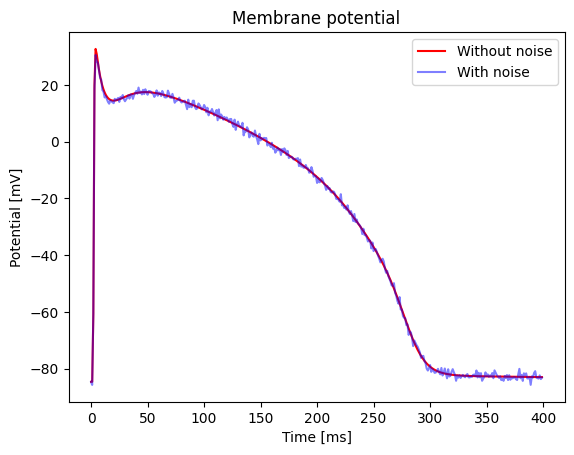

In [13]:
V = data[:, 0]
# noisy_V, noisy_c = noisy_data[:, 0], noisy_data[:, 1]
plt.plot(times, V, "-r", label="Without noise")
plt.plot(times, noisy_V, "-b", alpha=0.5, label="With noise")
plt.xlabel("Time [ms]")
plt.ylabel("Potential [mV]")
plt.legend()
plt.title("Membrane potential")
plt.savefig("simulation_outputs/time_series_tol.png")

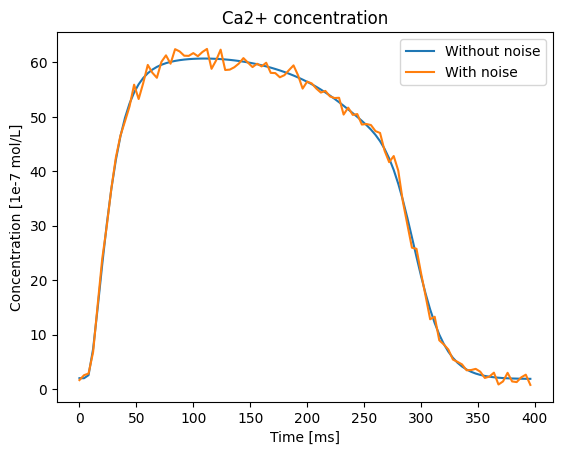

In [20]:
plt.plot(times, c, label="Without noise")
plt.plot(times, noisy_c, label="With noise")
plt.xlabel("Time [ms]")
plt.ylabel("Concentration [1e-7 mol/L]")
plt.legend()
plt.title("Ca2+ concentration")
plt.savefig("simulation_outputs/time_series_c.png")

## Using PINTS to perform inference

We will now perform Bayesian inference on the model to try and recover the values of the input parameters. Here, we use the CMAES-ACMC
combination by optimising the problem first to find starting parameters with CMAES and then using ACMC to perform Bayesian inference
on the parameters.

### Optimisation using `pints.CMAES`

We first use the optimiser to reach some realistic parameter values for the noisy data.

In [14]:
problem = pints.MultiOutputProblem(model, times, noisy_data)
score = pints.SumOfSquaresError(problem)

Next, choose some boundaries for the parameters. We know the signs of the Nernst potentials, as K$^{+}$ flows out of the cell
and Na$^{+}$, Ca$^{2+}$ flow into the cell. For the conductances, we assume that we can know their order of magnitude.

In [15]:
# boundaries = pints.RectangularBoundaries([0, 0, 0, 0, 0, 0],
#                                         [10, 0.1, 10, 1, 1, 1])
boundaries = pints.RectangularBoundaries([0, 0, 0, 0, 0, 0, 20, -100, -100, -100, -100, -100, -100],
                                        [10, 0.1, 10, 1, 1, 1, 100, -20, -20, -20, -20, -20, -20])
log_prior = pints.UniformLogPrior(boundaries)

C:\Users\matth\AppData\Local\Temp\ipykernel_10048\3026651079.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(boundaries)


In [16]:
num_opts = 10

And here we perform the optimisation. We choose to run this `num_opts` times to try and find the optimal solution of the different
optimised parameters. Each optimisation is deemed complete if the objective function has not changed by more than $10^{-8}$ over a
period of $200$ iterations. We save the parameters from each optimisation to a .csv file.

In [26]:
for j in range(2, num_opts):
    xs = log_prior.sample(1)
    # sigma = [0.1, 0.001, 0.1, 0.01, 0.01, 0.01, 1, 1, 1, 1, 1, 1, 1]
    # transform = pints.RectangularBoundariesTransformation(boundaries)
    opt = pints.OptimisationController(score, xs, boundaries=boundaries, method=pints.CMAES)
    opt.set_max_unchanged_iterations(200, 0.00000001)
    opt.set_max_iterations(2500)
    opt_params, opt_values = opt.run()
    opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(model.n_parameters())})
    opt_param_df.to_csv(f"optimisation_outputs/parameters_tol_all_new/opt_params_{j}.csv")

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 11
Iter. Eval.  Best      Current   Time m:s
0     11      622340.7  622340.7   0:00.9
1     22      540196.8  540196.8   0:01.5
2     33      500959.2  500959.2   0:02.3
3     44      500959.2  518778.7   0:02.9
20    231     129182.7  278704.5   0:14.9
40    451     45221.73  69811.5    0:30.5
60    671     41507.98  49753.62   0:47.3
80    891     39415.98  51864.43   1:07.0
100   1111    39415.98  51418.77   1:26.4
120   1331    38491.1   39170.45   1:47.3
140   1551    37867.12  37890.4    2:06.0
160   1771    33889.55  35637.07   2:25.3
180   1991    31738.98  31738.98   2:48.3
200   2211    28790.92  29139.62   3:08.5
220   2431    24583.98  25173.87   3:29.0
240   2651    23951.54  24179.39   3:50.3
260   2871    23733.05  23733.05   4:11.5
280   3091    23050.12  23050.12   4:32.1
300   3311    22469.44  22469.44   4:54.2
320   3531    21640.81  

If the optimisation has not converged, but has a sufficiently low score, we will take the parameters at this stage.

In [24]:
opt_params = opt.optimiser().x_best()
# opt_params = (boundaries.lower() + boundaries.upper()*exp(transformed_opt_params))/(1 + exp(transformed_opt_params))

Save these parameters to a .csv file and then read from the file afterwards.

In [20]:
import pandas as pd

In [25]:
opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(model.n_parameters())})
opt_param_df.to_csv(f"optimisation_outputs/parameters_tol_all_new/opt_params_{1}.csv")

### Plotting with optimised parameters 

In [29]:
opt_params = []
num_opts = 10
for j in range(num_opts):
    opt_param_df = pd.read_csv(f"optimisation_outputs/parameters_tol_all_new/opt_params_{j}.csv", index_col=0)
    opt_params.append(opt_param_df.to_numpy()[0])

In [30]:
errors = []
true_error = score(parameters)
print("---------------------------------------------------------------------------")
print(f"True parameters, sum of squared errors = {round(true_error, 5)}")
for j in range(num_opts):
    print("---------------------------------------------------------------------------")
    error = score(opt_params[j])
    print(f"Optimisation {j}, sum of squared errors = {round(error, 5)}")
    print("---------------------------------------------------------------------------")
    errors.append(error)
    output_list = []
    for i in range(model.n_parameters()):
        opt_param = round(opt_params[j][i], 5)
        output_list.append(opt_param)
        print(f"Parameter: {param_names[i]}, True: {parameters[i]}, Optimised: {opt_param}")
    output_param_df[f"Optimisation {j}"] = output_list

---------------------------------------------------------------------------
True parameters, sum of squared errors = 382.64655
---------------------------------------------------------------------------
Optimisation 0, sum of squared errors = 363.16506
---------------------------------------------------------------------------
Parameter: g_Na, True: 4.0, Optimised: 4.06675
Parameter: g_NaC, True: 0.003, Optimised: 0.00329
Parameter: g_K1, True: 1.4, Optimised: 1.68969
Parameter: g_K2, True: 0.07, Optimised: 0.06024
Parameter: g_x, True: 0.8, Optimised: 0.91699
Parameter: g_Ca, True: 0.09, Optimised: 0.08639
Parameter: V_Na, True: 50.0, Optimised: 47.28078
Parameter: V_K1, True: -85.0, Optimised: -85.03883
Parameter: V_K2, True: -53.0, Optimised: -56.61595
Parameter: V_K3, True: -23.0, Optimised: -31.95826
Parameter: V_x1, True: -77.0, Optimised: -76.21889
Parameter: V_x2, True: -35.0, Optimised: -38.88241
Parameter: V_Ca, True: -82.3, Optimised: -81.99967
------------------------------

In [31]:
chosen_opt = 3

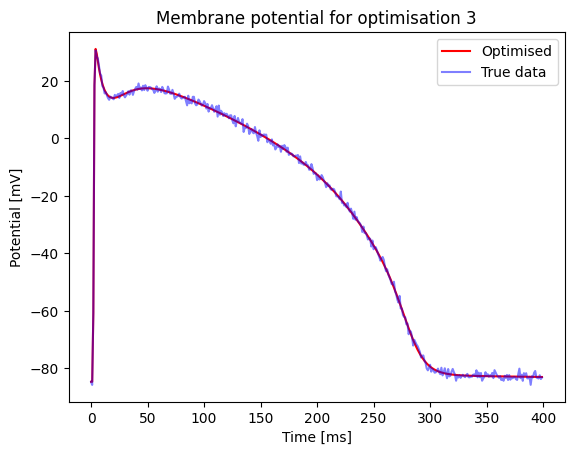

In [32]:
opt_soln = model.simulate(opt_params[chosen_opt], times)
# opt_V, opt_c = opt_soln[:, 0], opt_soln[:, 1]
opt_V = opt_soln[:, 0]
plt.plot(times, opt_V, "-r", label="Optimised")
plt.plot(times, noisy_V, "-b", alpha=0.5, label="True data")
plt.xlabel("Time [ms]")
plt.ylabel("Potential [mV]")
plt.legend()
plt.title(f"Membrane potential for optimisation {chosen_opt}")
plt.savefig(f"optimisation_outputs/time_series_tol_all_new_{chosen_opt}.png")

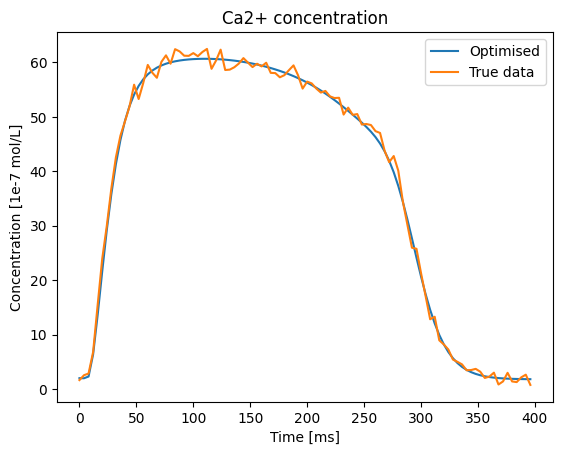

In [29]:
plt.plot(times, opt_c, label="Optimised")
plt.plot(times, noisy_c, label="True data")
plt.xlabel("Time [ms]")
plt.ylabel("Concentration [1e-7 mol/L]")
plt.legend()
plt.title("Ca2+ concentration")
plt.savefig(f"optimisation_outputs/time_series_c_{chosen_opt}.png")

### Inference using `pints.HaarioBardenetACMC`

In [33]:
log_likelihood = pints.GaussianLogLikelihood(problem)
composed_log_prior = pints.ComposedLogPrior(log_prior,
                                            pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf),
                                            # pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf)
                                           )
log_posterior = pints.LogPosterior(log_likelihood, composed_log_prior)

### Initialising chains

Here, we initialise the chain with the optimised parameters. We only need one chain for our purpose as we use
parameters close to the true value.

In [34]:
# xs = np.tile(np.array(opt_params[chosen_opt].tolist() + [1] + [1]), (1, 1))
xs = np.tile(np.array(opt_params[chosen_opt].tolist() + [1]), (1, 1))
num_chains = 1
# transform = pints.RectangularBoundariesTransformation([0, 0, 0, 0, 0, 0, 0, 0],
#                                         [10, 1, 10, 1, 1, 1, 10, 10])
# transform = pints.RectangularBoundariesTransformation([0, 0, 0, 0, 0, 0, 0],
#                                         [10, 1, 10, 1, 1, 1, 10])
transform = pints.RectangularBoundariesTransformation([0, 0, 0, 0, 0, 0, 20, -100, -100, -100, -100, -100, -100, 0],
                                        [10, 1, 10, 1, 1, 1, 100, -20, -20, -20, -20, -20, -20, 10])

### Performing inference

In [ ]:
n_params = log_prior.n_parameters()
mcmc = pints.MCMCController(log_posterior, num_chains, xs, method=pints.HaarioBardenetACMC, transformation=transform)
max_iterations = 100000
mcmc.set_max_iterations(max_iterations)
# mcmc.set_parallel(True)
# print(mcmc.parallel())

chains = mcmc.run()

Using Haario-Bardenet adaptive covariance MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:00.2
1     2      0          0:00.3
2     3      0          0:00.5
3     4      0          0:00.6
20    21     0          0:02.7
40    41     0          0:05.3
60    61     0          0:07.9
80    81     0          0:10.4
100   101    0          0:13.0
120   121    0          0:15.5
140   141    0          0:18.0
160   161    0          0:20.5
180   181    0          0:23.1
Initial phase completed.
200   201    0          0:25.5
220   221    0          0:28.2
240   241    0.0249     0:30.9
260   261    0.0613     0:33.5
280   281    0.113879   0:36.2
300   301    0.14       0:38.8
320   321    0.162      0:41.6
340   341    0.179      0:44.1
360   361    0.191      0:46.9
380   381    0.189      0:49.6
400   401    0.204      0:52.1
420   421    0.209      0:55.0
440   441    0.211      0:58.4
460   461    0.213      1:02.9
480   481  

If we haven't quite reached the limit, save the chains here.

In [34]:
# mcmc.set_max_iterations(5020)
# chains = mcmc.run()
# chains = mcmc.chains()

RuntimeError: Controller is valid for single use only

### Saving chains

In [36]:
import pandas as pd

In [37]:
# all_param_names = param_names + ["sigma_V", "sigma_c"]
all_param_names = param_names + ["sigma_V"]

In [38]:
for i, chain in enumerate(chains):
    df = pd.DataFrame(chain, columns=all_param_names)
    df.to_csv(f"chain_data/all_params_tol_new/chain_{i}.csv")

## Plots

### Recovering chains from .csv files

In [39]:
num_chains = 1
list_of_chains = []
for i in range(num_chains):
    df = pd.read_csv(f"chain_data/all_params_tol_new/chain_{i}_end.csv", index_col=0)
    chain = df.to_numpy()
    list_of_chains.append(chain)
chains = np.array(list_of_chains)

### Trace plots

In [40]:
import setuptools

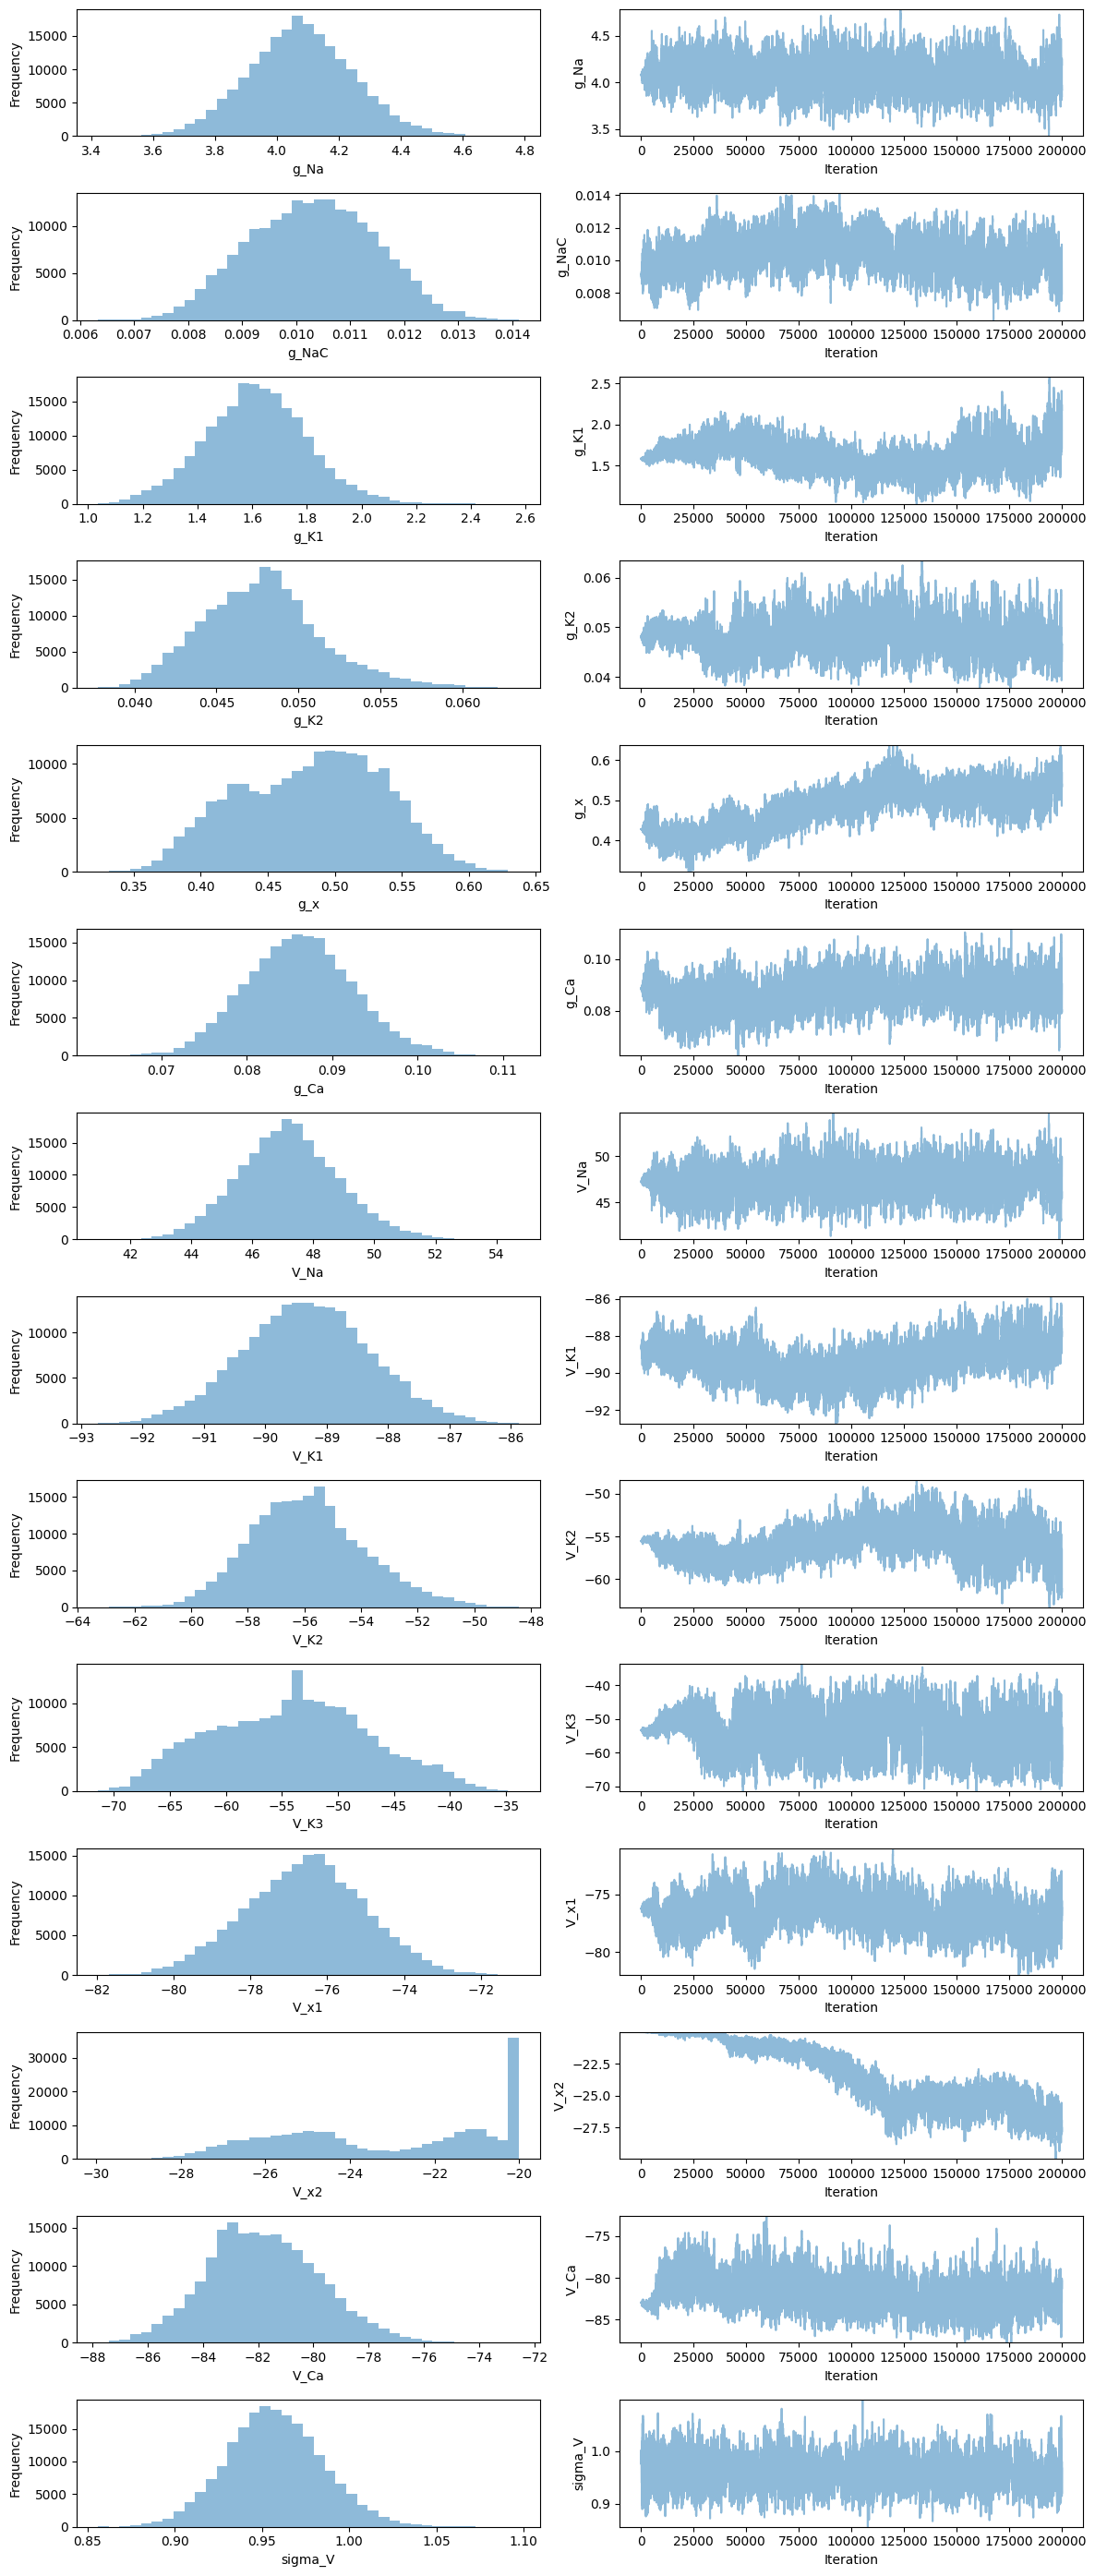

In [41]:
import pints.plot
pints.plot.trace(chains, parameter_names=all_param_names)
plt.show()

### Diagnosing using $\hat{R}$

Here we find the $\hat{R}$ measure for the inference for all different parameters. For well mixed and stationary chains, $\hat{R}$ is close to $1$.

In [43]:
r_hat_values = pints.rhat(chains, warm_up=0.95)
for i in range(len(all_param_names)):
    print(f"R_hat value for {all_param_names[i]}: {round(r_hat_values[i], 5)}")
output_param_df["R hat"] = r_hat_values[:-1]

R_hat value for g_Na: 1.09599
R_hat value for g_NaC: 1.17669
R_hat value for g_K1: 1.01613
R_hat value for g_K2: 1.0278
R_hat value for g_x: 1.1213
R_hat value for g_Ca: 1.01392
R_hat value for V_Na: 1.07116
R_hat value for V_K1: 1.06622
R_hat value for V_K2: 1.01735
R_hat value for V_K3: 1.01379
R_hat value for V_x1: 1.16099
R_hat value for V_x2: 1.00501
R_hat value for V_Ca: 1.15768
R_hat value for sigma_V: 1.00637


In [48]:
xs = np.tile(chains[0, -1, :], (1, 1))
print(xs)

[[ 4.18812040e+00  7.94077535e-03  2.17657366e+00  4.65559881e-02
   5.38907864e-01  8.01514539e-02  4.60698749e+01 -8.77915024e+01
  -6.11703047e+01 -5.24894220e+01 -7.56712964e+01 -2.69614967e+01
  -8.04034305e+01  9.66559752e-01]]


Next, calculate the effective sample size, a measure of how many truly independent samples the MCMC algorithm has produced.

In [67]:
for j, chain in enumerate(chains):
    ess = pints.effective_sample_size(chain)
    for i in range(len(all_param_names)):
        print(f"Effective sample size for chain {j}, param {all_param_names[i]} = {round(ess[i], 5)}")
output_param_df["Effective Sample Size"] = ess[:-1]

KeyboardInterrupt: 

We will now discount the first part of the iterations.

In [106]:
fraction = 1 / 10
chains = chains[:, -int(fraction * max_iterations):]

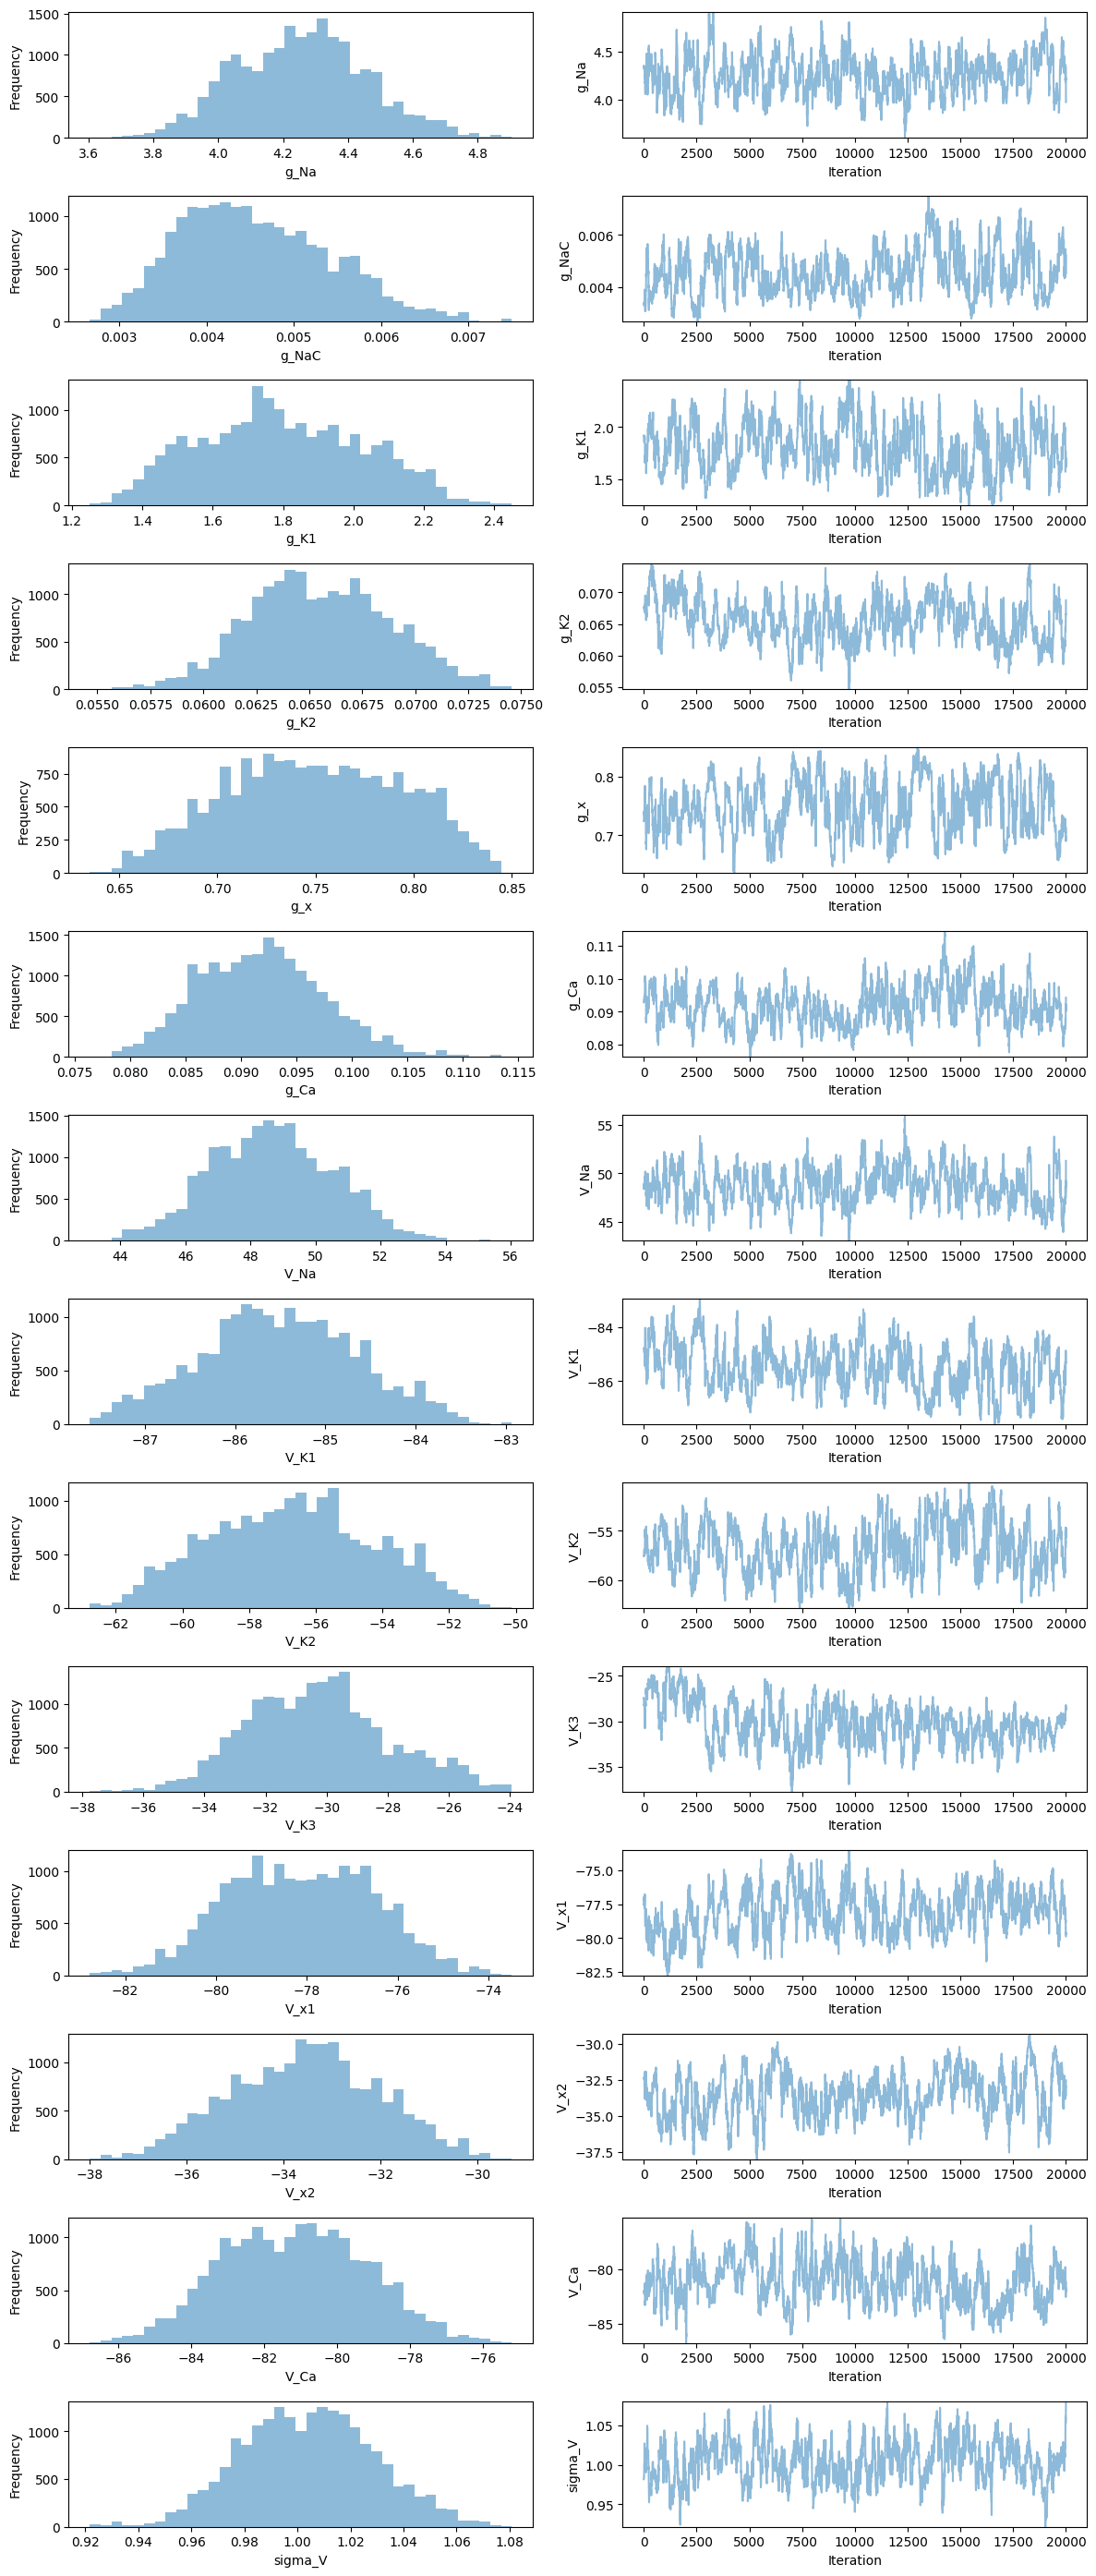

In [84]:
pints.plot.trace(chains, parameter_names=all_param_names)
plt.show()

### Predicted time series plots

#### Chain 1

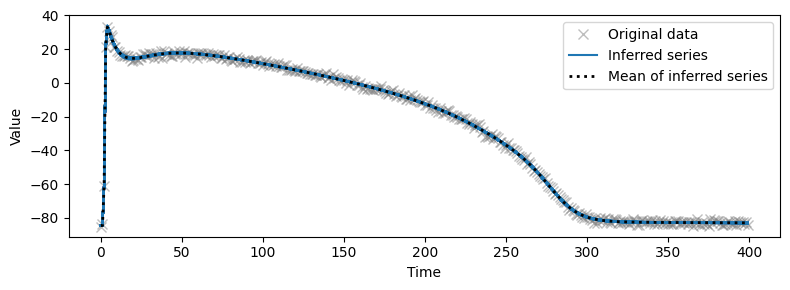

In [85]:
pints.plot.series(chains[0, :], problem)
plt.savefig("inference_outputs/series_all_params_tol.png")

### Pairwise plots

Here we will see which parameters are most correlated.

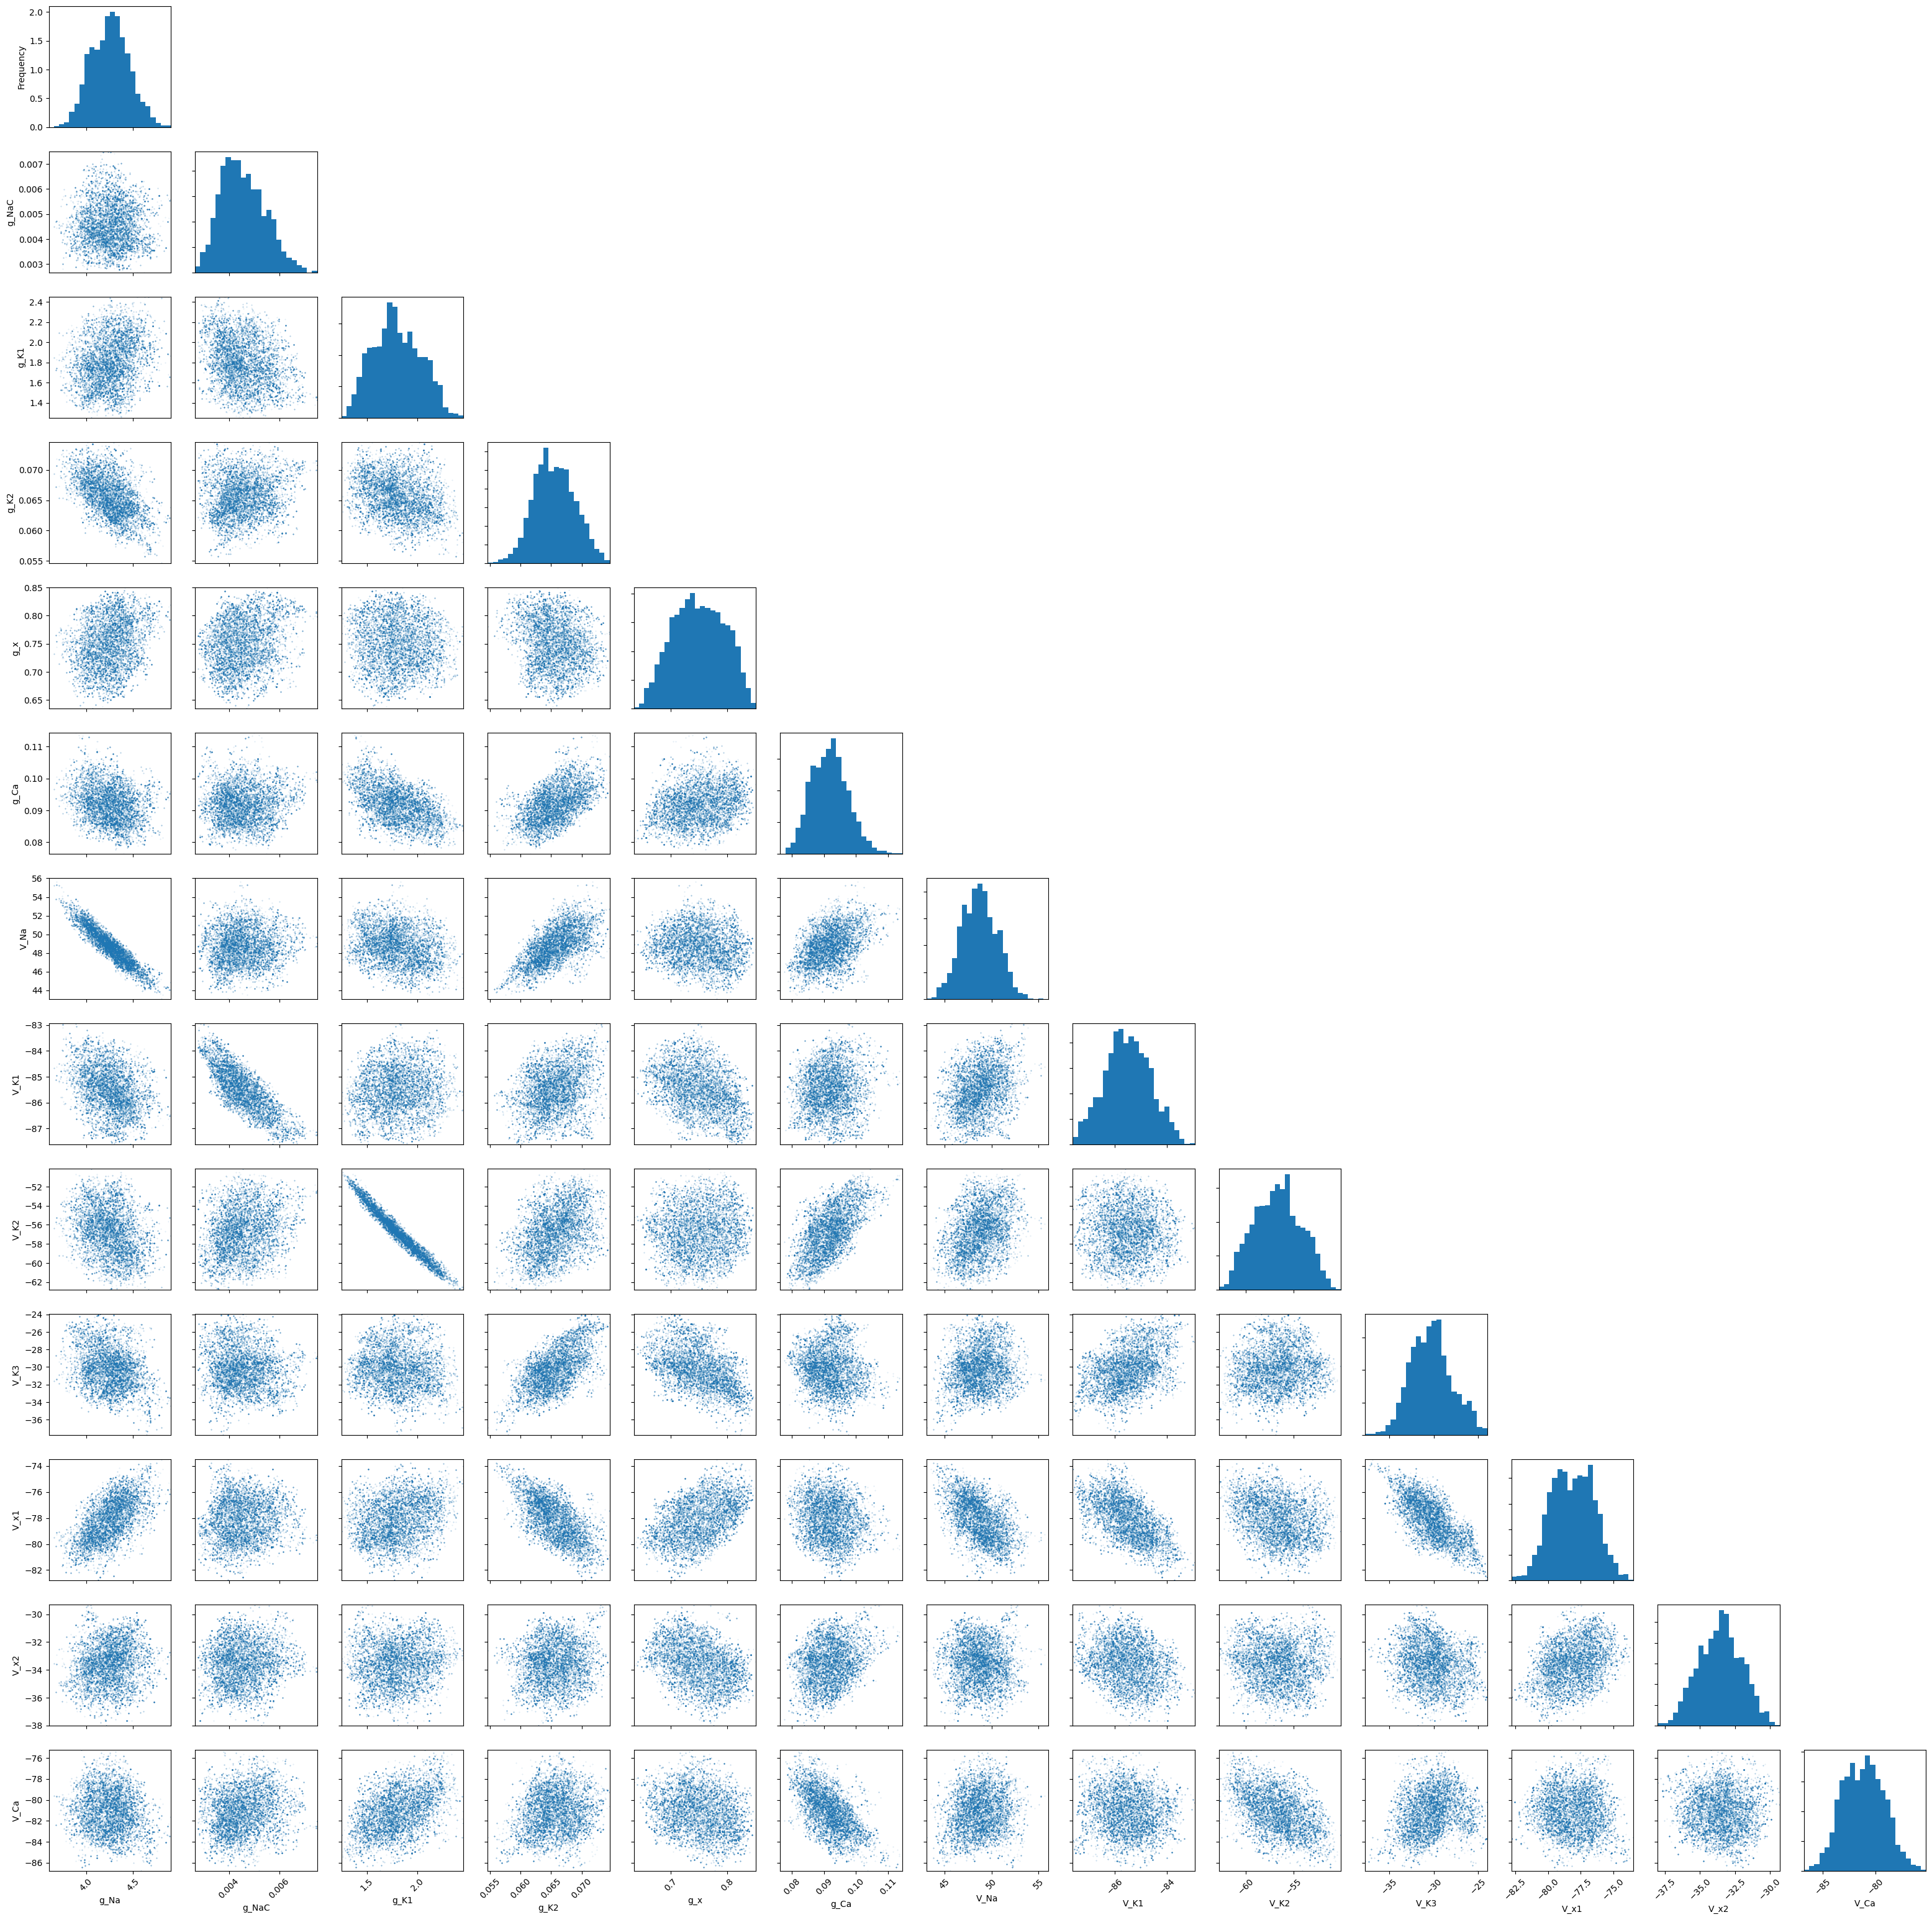

In [86]:
pints.plot.pairwise(chains[0, :, :-1], parameter_names=all_param_names[:-1])
plt.savefig("inference_outputs/pairwise_all_params_tol.png")

## Extracting posterior distributions

Finally, we will use the stationary chain data to extract posteriors. Assuming chains have converged, we can use their 
iterations as samples from the posterior.

In [87]:
chains_df = pd.DataFrame(columns=all_param_names + ['chain'])
for i in range(num_chains):
    chain_i_df = pd.DataFrame(chains[i], columns=all_param_names)
    chain_i_df['chain'] = [i] * len(chain_i_df)
    chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_22176\1106702706.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)


Mean g_Na: 4.25703558197914, std dev g_Na: 0.2021019132088292
Mean g_NaC: 0.004570402161370983, std dev g_NaC: 0.0008634019272408027
Mean g_K1: 1.7977607416218848, std dev g_K1: 0.232070010488124
Mean g_K2: 0.06553549166089391, std dev g_K2: 0.00331420820941246
Mean g_x: 0.7494776454863054, std dev g_x: 0.04446511089824403
Mean g_Ca: 0.09182289440729892, std dev g_Ca: 0.005636647536340446
Mean V_Na: 48.68044920010805, std dev V_Na: 1.8662536366853872
Mean V_K1: -85.50742572381562, std dev V_K1: 0.8678848919140775
Mean V_K2: -56.686472778690444, std dev V_K2: 2.4296845660924054
Mean V_K3: -30.246659522770386, std dev V_K3: 2.3335899504001847
Mean V_x1: -78.12520134445033, std dev V_x1: 1.6111928067545949
Mean V_x2: -33.551777708013766, std dev V_x2: 1.522431996734657
Mean V_Ca: -81.15875285823267, std dev V_Ca: 1.961506643373702


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


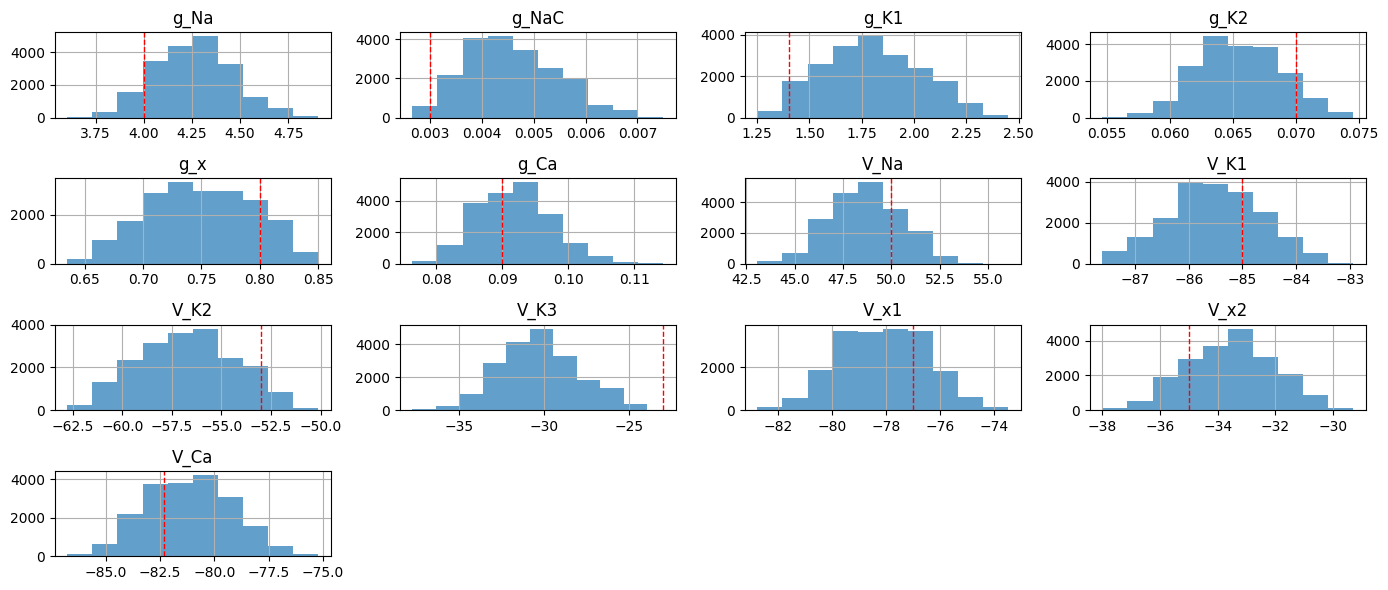

In [107]:
means = []
std_devs = []
for name in param_names:
    mean = np.mean(chains_df[name])
    std_dev = np.std(chains_df[name])
    print(f"Mean {name}: {mean}," 
          f" std dev {name}: {std_dev}")
    means.append(mean)
    std_devs.append(std_dev)
output_param_df["Posterior mean"] = means
output_param_df["Posterior std dev"] = std_devs
num_rows = 4
num_columns = 4
histograms = chains_df.hist(column=param_names, alpha=0.7, layout=(num_rows, num_columns), figsize=(14, 6))
num_params = len(param_names)
for row in range(num_rows):
    figs_in_row = num_columns
    if row == num_rows - 1:
        figs_in_row = num_params % num_columns
    for column in range(figs_in_row):
        ax = histograms[row][column]
        ax.axvline(parameters[row * num_columns + column], color='r', linestyle='dashed', linewidth=1, label="True")
plt.tight_layout()
plt.legend()
plt.savefig("inference_outputs/posteriors_all_params_tol.png")

Finally, write all of the parameter data to a final .csv file

In [108]:
output_param_df.insert(0, "Name", all_param_names[:-1])
output_param_df.to_csv("param_info_tol_all.csv")

## Plotting the likelihood surface

Following [$^{[4]}$](#Sources), we wish to plot the likelihood surface to see if there are any discontinuities. This may imply that the differential
equation solver is of the incorrect tolerance.

In [105]:
parameters = [4, 0.003, 1.4, 0.07, 0.8, 0.09, 1.0]
likelihoods = []
g_Na_list = []
for i in range(100):
    g_Na = i / 10
    g_Na_list.append(g_Na)
    parameters[0] = g_Na
    llhd = log_likelihood(np.array(parameters))
    likelihoods.append(llhd)
    print(f"g_Na: {g_Na}, likelihood: {llhd}")

g_Na: 0.0, likelihood: -230825.4279941542
g_Na: 0.1, likelihood: -227793.23206179112
g_Na: 0.2, likelihood: -223437.178657597
g_Na: 0.3, likelihood: -218124.70634077454
g_Na: 0.4, likelihood: -211696.59772762164
g_Na: 0.5, likelihood: -203172.07313776435
g_Na: 0.6, likelihood: -189758.9461445217
g_Na: 0.7, likelihood: -158273.9285418699
g_Na: 0.8, likelihood: -16060.204791626156
g_Na: 0.9, likelihood: -8942.724559160706
g_Na: 1.0, likelihood: -6122.1619735675995
g_Na: 1.1, likelihood: -4528.628931141807
g_Na: 1.2, likelihood: -3504.4196621556916
g_Na: 1.3, likelihood: -2791.3518198604243
g_Na: 1.4, likelihood: -2269.43588362649
g_Na: 1.5, likelihood: -1873.1987251956193
g_Na: 1.6, likelihood: -1563.991967985548
g_Na: 1.7, likelihood: -1317.735760918626
g_Na: 1.8, likelihood: -1118.4567777146904
g_Na: 1.9, likelihood: -955.1251905361553
g_Na: 2.0, likelihood: -819.8192469201631
g_Na: 2.1, likelihood: -707.1754753289288
g_Na: 2.2, likelihood: -612.6002020309847
g_Na: 2.3, likelihood: -53

Text(0.5, 1.0, 'Likelihood surface varying the g_Na parameter')

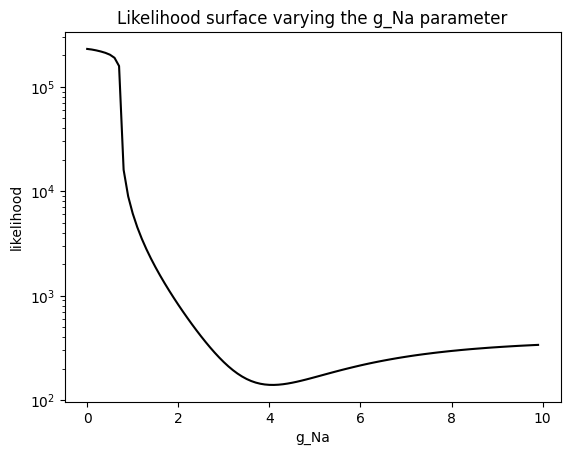

In [106]:
plt.yscale("log")
plt.plot(np.array(g_Na_list), -np.array(likelihoods), "-k")
plt.xlabel("g_Na")
plt.ylabel("likelihood")
plt.title("Likelihood surface varying the g_Na parameter")

In [107]:
def plot_likelihood(param_index, param_name, upper_bound):
    parameters = [4, 0.003, 1.4, 0.07, 0.8, 0.09, 1.0]
    likelihoods = []
    param_list = []
    for i in range(100):
        param = i / 100 * upper_bound
        param_list.append(param)
        parameters[param_index] = param
        llhd = log_likelihood(np.array(parameters))
        likelihoods.append(llhd)
    plt.yscale("log")
    plt.plot(np.array(param_list), -np.array(likelihoods), "-k")
    plt.xlabel(param_name)
    plt.ylabel("likelihood")
    plt.title(f"Likelihood surface varying the {param_name} parameter")

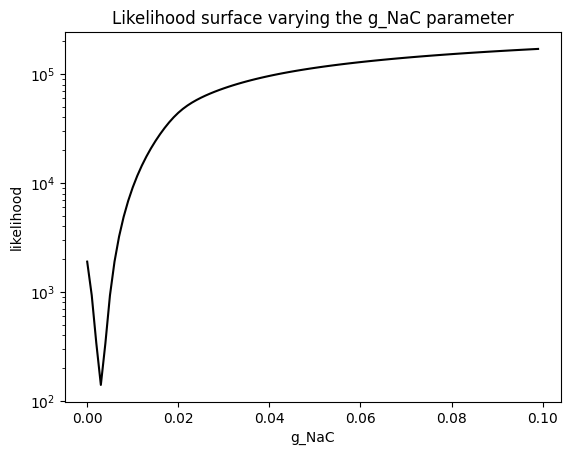

In [108]:
plot_likelihood(1, "g_NaC", 0.1)

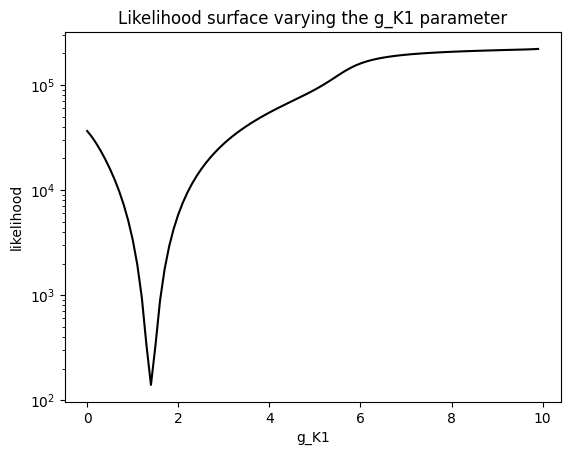

In [109]:
plot_likelihood(2, "g_K1", 10)

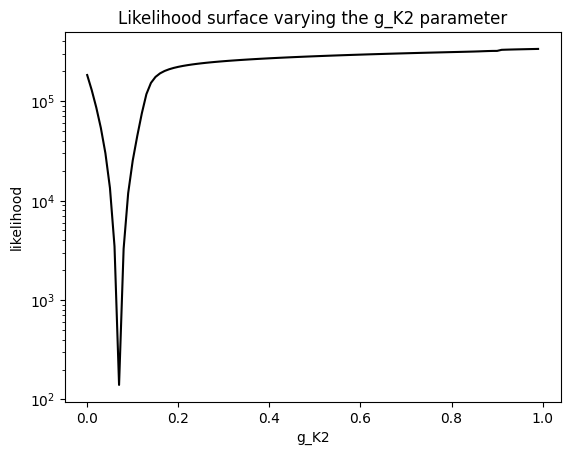

In [110]:
plot_likelihood(3, "g_K2", 1)

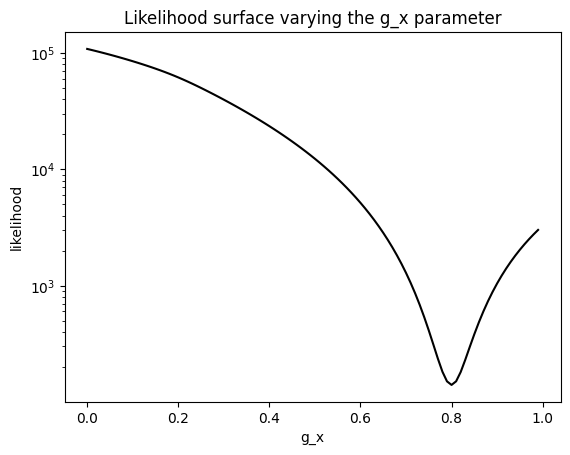

In [111]:
plot_likelihood(4, "g_x", 1)

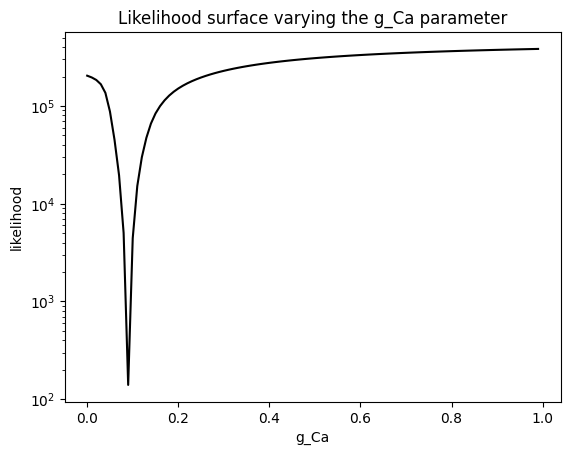

In [112]:
plot_likelihood(5, "g_Ca", 1)

## Sources
$^{[1]}$ J. Keener and J. Sneyd (1998) - Mathematical Physiology https://link.springer.com/book/10.1007/b98841

$^{[2]}$ G. W. Beeler and H. Reuter, RECONSTRUCTION OF THE ACTION POTENTIAL OF
VENTRICULAR MYOCARDIAL FIBRES, J. Physiol. **268** (1977), pp. 177-210 https://doi.org/10.1113/jphysiol.1977.sp011853

$^{[3]}$ P. Noble, F. Fenton, cellML - Beeler, Reuter 1997, date accessed: 22/03/24, https://models.cellml.org/e/1

$^{[4]}$ R. Creswell, K. M. Shepherd, B. Lambert, G. R. Mirams, C. L. Lei, S. Tavener, M. Robinson and D. J. Gavaghan, Understanding the impact of numerical solvers on inference for differential equation modelsial, J. R. Soc. Interface **21** (2024) pp. 202303https://pubmed.ncbi.nlm.nih.gov/38442857/dels